In [9]:
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [10]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

## block MABs

In [11]:
from MultiArmedBandit import MultiArmedBandit
from BlockMABs import BlockMABs

In [12]:
n_rounds = 10
start_arm = 0
end_arm = 5
rules = ['add'] #'chngpnt'


n_arms = (end_arm - start_arm) + 1
n_rounds_per_kernel = 1 # per function
n_blocks = 1 # unused paramter
n_trials = 10 # unused

noise_per_arm = True # per arm
noise_var = 0.1
normalize_rewards = True
cue_per_epoch = True
composition_block = True

CUES =  {'linear': [0, 0],  'periodic': [0, 0], 'linperiodic': []}
ctx_dim = len(CUES['linear'])
n_cues = len(CUES)
aoi = {'linear': 7, 'periodic': 1, 'linperiodic': 6}   
BESTARMS = {'negodd':[0, [1, 3, 5] , 1], 'negeven':[0, [0, 2, 4] , 0], 
            'posodd':[5, [1, 3, 5] , 5], 'poseven':[5, [0, 2, 4] , 4]}

In [13]:
bandit = MultiArmedBandit(seed=seed_val, cues=CUES, start_arm=start_arm, end_arm=end_arm,
                          normalize=False, noise_per_arm=noise_per_arm, noise_var=noise_var,
                          to_list=True)
task = BlockMABs(bandit, seed=seed_val, num_blocks=n_blocks, composition_block=composition_block, num_rounds=n_rounds_per_kernel, rule=rules, 
                 normalize=normalize_rewards, evaluate=True)

TypeError: __init__() got an unexpected keyword argument 'start_arm'

In [7]:
block = ['linpos', 'pereven', 'linperiodic']
#X, Y, S, P = task.sample(end_rnd=n_rounds, block=block, apply_rule=rules[0])

In [18]:
X, Y, S, P = [], [], [], []
for _ in range(n_rounds):
    x, y, s, p = task.sample(end_rnd=1, block=block, apply_rule=rules[0])
#     x, y, s, _ = task.prepare_data(x, y, s, block, n_trials)
    X.append(x)
    Y.append(y)
    S.append(s)
    P.append(p)

X = torch.stack(X).squeeze(1)
Y = torch.stack(Y).squeeze(1)
S = torch.stack(S).squeeze(1)

In [19]:
torch.save(Y, 'runs')

In [19]:
for lin, per, linper in zip(P[0::3], P[1::3], P[2::3]):
    linper.update(lin)
    linper.update(per)

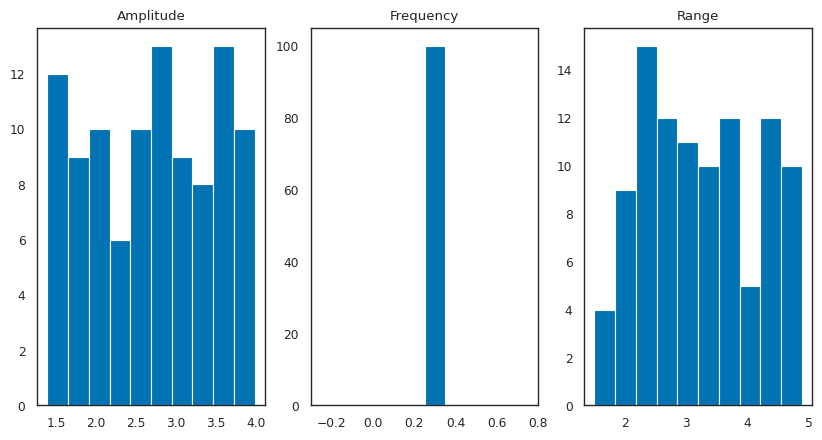

In [20]:
# subtask 0
subtaskID = 0
params = [param[block[subtaskID]][0] for param in P[subtaskID::3]]
f, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=100)
_ = ax[0].hist(params)
if block[subtaskID][:3] == 'per':
    ax[0].set(title='Amplitude')
else:
    ax[0].set(title='Slope')

params = [param[block[subtaskID]][1] for param in P[subtaskID::3]]
_ = ax[1].hist(params)
if block[subtaskID][:3] == 'per':
    ax[1].set(title='Frequency')
else:
    ax[1].set(title='Bias')

if block[subtaskID][:3] == 'per':
    params = [param[block[subtaskID]][3] for param in P[subtaskID::3]]
else:
    params = [param[block[subtaskID]][2] for param in P[subtaskID::3]]
    
_ = ax[2].hist(params)
ax[2].set(title='Range')

plt.show()

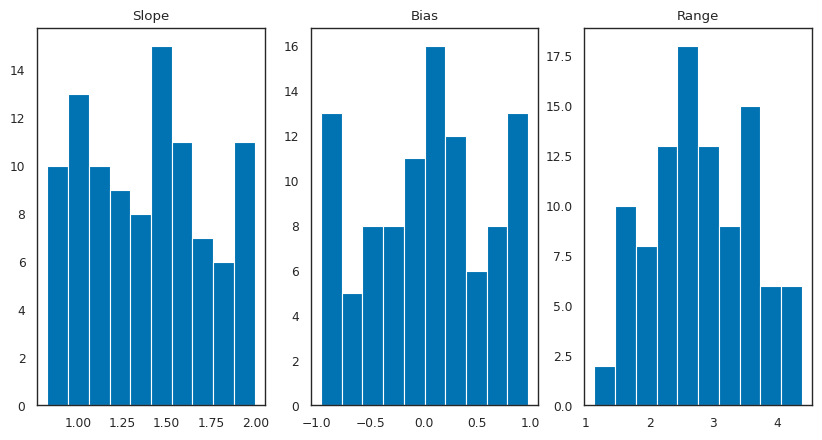

In [21]:
# subtask 1
subtaskID = 1
params = [param[block[subtaskID]][0] for param in P[subtaskID::3]]
f, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=100)
if block[subtaskID][:3] == 'per':
    ax[0].set(title='Amplitude')
else:
    ax[0].set(title='Slope')
_ = ax[0].hist(params)

params = [param[block[subtaskID]][1] for param in P[subtaskID::3]]
_ = ax[1].hist(params)
if block[subtaskID][:3] == 'per':
    ax[1].set(title='Freq')
else:
    ax[1].set(title='Bias')

if block[subtaskID][:3] == 'per':
    params = [param[block[subtaskID]][3] for param in P[subtaskID::3]]
else:
    params = [param[block[subtaskID]][2] for param in P[subtaskID::3]]
_ = ax[2].hist(params)
ax[2].set(title='Range')

plt.show()

## Visualize Data

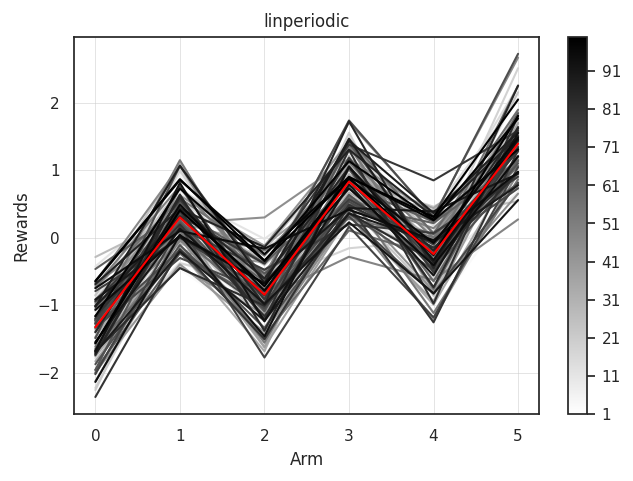

In [22]:
block_id = 2
cue = block[block_id]

#set up the color scheme
c = np.arange(n_rounds) + 1
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray_r)
cmap.set_array([])
round_label = np.arange(1, n_rounds+1, 10)

# set up figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=125)
arms = ['A', 'S', 'D', 'F', 'J', 'K', 'L', ';']
for rnd_ix in range(block_id, len(block)*n_rounds, 3):
    ax.plot(Y[rnd_ix].T.numpy(), c=cmap.to_rgba(rnd_ix/3 + 1))
ax.plot(Y[range(block_id, len(block)*n_rounds, 3)].mean(0), c='red')
    # ax.plot(((Y[rnd_ix] + Y[n_rounds+rnd_ix])/2).T.numpy(), c=cmap.to_rgba(rnd_ix + 1))
ax.grid(lw=0.3)
ax.set(title = cue, xlabel='Arm', ylabel='Rewards')
cbar = plt.colorbar(cmap, ticks=round_label, ax=ax)
# cbar.set_label('Samples', rotation=90)
plt.show()

## Store data

## test data structures

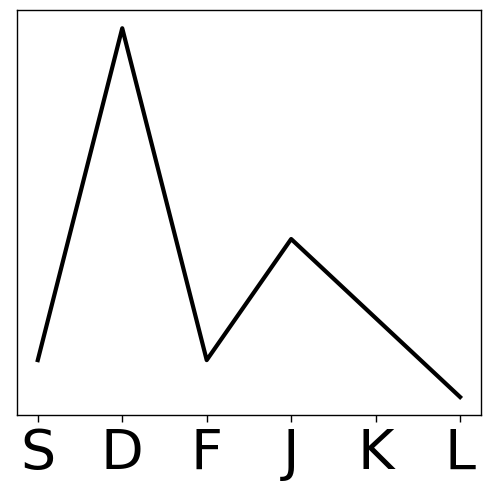

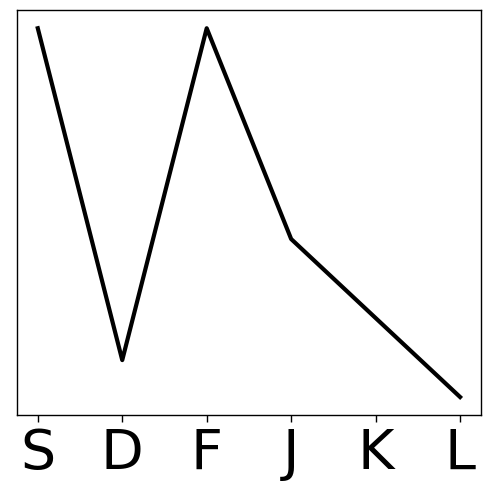

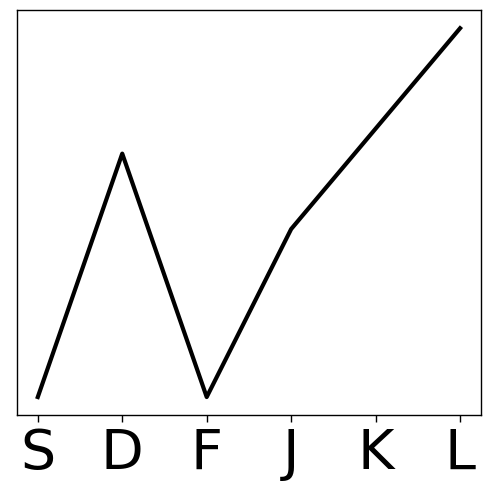

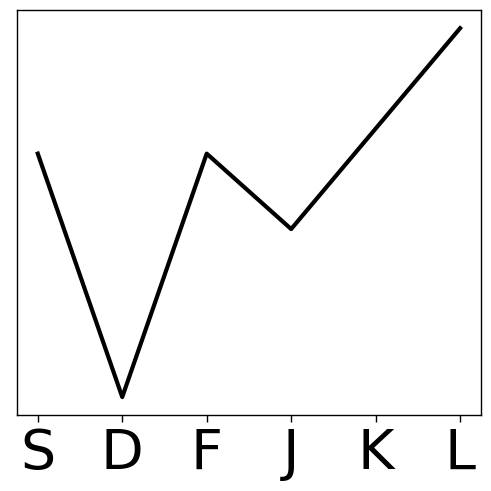

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
import sys
sys.path.append('/notebooks/models/metaRL/')
from tasks.sample_data import sample_rewards

rule = 'changepoint'
condition = 'compositional'
n_runs = 1
seed = 0
FONTSIZE = 40
for lin in ['linneg', 'linpos']:
    for per in ['perodd', 'pereven']:
        # sample data
        block = [per, lin, 'linperiodic']
        description = block if condition == 'compositional' else ['linperiodic']
        _, Y, _ = sample_rewards(n_runs, block, rule, seed_val=seed, noise_per_arm=False, noise_var=0)
        # set up figure
        f, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

        ax.plot(Y[0, 2].T.numpy(), c='k', lw=3)
        arms = ['S', 'D', 'F', 'J', 'K', 'L']
        plt.xticks(np.arange(6), arms, fontsize=FONTSIZE)
        plt.yticks([])
#         sns.despine()
        f.tight_layout()
        f.savefig('/notebooks/figs/NeurIPS/{}_{}_{}.svg'.format(block[0], block[1], rule), bbox_inches = 'tight')
        plt.show()